<h2 id="toc">목차</h2>

1. [초기 세팅](#contents1)
    1. [라이브러리 불러오기](#contents1-1)
    2. [데이터 로드](#contents1-2)
2. [문제 난이도 예측](#contents2)
    1. [Feature selection](#contents2-1)
    2. [범주형 변수 전처리](#contents2-2)
    3. [스케일링](#contents2-3)
    4. [스케일링 방식 결정](#contents2-4)
    5. [Target변수 전처리](#contents2-5)
    6. [모델 학습](#contents2-6)
    7. [모델 성능 시각화](#contents2-7)
    8. [모델 선정](#contents2-8)
    9. [특성 중요도 확인](#contents2-9)
    10. [unseen 데이터 테스트](#contents2-10)

<h3 id="contents1">1. 초기 세팅</h3>

[⬆ 목차로](#toc)

---

<h4 id="contents1-1">1-1. 라이브러리 불러오기</h4>

[⬆ 목차로](#toc)

---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split, GridSearchCV, KFold
)
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from tqdm import tqdm  # 프로그레스바 출력
import warnings
# 경고메세지 무시
warnings.filterwarnings("ignore")

from paths import PROCESSED_DATA

<h4 id="contents1-2">1-2. 데이터 로드</h4>

[⬆ 목차로](#toc)

---

In [ ]:
df = pd.read_csv(PROCESSED_DATA, encoding='utf-8-sig')
df.columns

Index(['question_number', 'answer', 'difficulty', 'score', 'accuracy_rate',
       'option1', 'option2', 'option3', 'option4', 'option5', 'subject',
       'exam_date', 'exam_type', 'ocr_text_raw', 'ocr_text_clean',
       'ocr_text_tokens', 'ocr_has_latex', 'question_type'],
      dtype='object')

<h3 id="contents2">2. 문제 난이도 예측</h3>

[⬆ 목차로](#toc)

---

<h4 id="contents2-1">2-1. Feature selection</h4>

[⬆ 목차로](#toc)

---


`난이도` 컬럼에 영향을 줄만한 컬럼들을 Feature로 선택해야 합니다

`score`, `answer`, `option1`, `option2`, `option3`, `option4`, `option5`, `subject`, `exam_type`, `exam_date`, `question_type`

df에서 해당 컬럼들을 추출하고 X라는 변수에 저장합니다

타겟 변수 `difficulty`도 y라는 변수에 저장합니다

In [3]:
X = df.loc[:, ['score', 'answer', 'option1', 'option2', 'option3', 'option4', 'option5', 
                      'subject', 'exam_type', 'exam_date', 'question_type']]
y = df['difficulty']

X

,score,answer,option1,option2,option3,option4,option5,subject,exam_type,exam_date,question_type
0,2,5,0.02,0.02,0.02,0.03,0.91,확률과통계,학력평가,2025-05-08,객관식
1,2,1,0.91,0.02,0.02,0.04,0.02,확률과통계,학력평가,2025-05-08,객관식
2,3,3,0.02,0.03,0.86,0.06,0.02,확률과통계,학력평가,2025-05-08,객관식
3,3,1,0.90,0.03,0.03,0.02,0.01,확률과통계,학력평가,2025-05-08,객관식
4,3,4,0.01,0.02,0.03,0.92,0.02,확률과통계,학력평가,2025-05-08,객관식
...,...,...,...,...,...,...,...,...,...,...,...
4735,4,20,0.00,0.00,0.00,0.00,0.00,수학(나),학력평가,2016-03-10,주관식
4736,4,256,0.00,0.00,0.00,0.00,0.00,수학(나),학력평가,2016-03-10,주관식
4737,4,4,0.00,0.00,0.00,0.00,0.00,수학(나),학력평가,2016-03-10,주관식
4738,4,336,0.00,0.00,0.00,0.00,0.00,수학(나),학력평가,2016-03-10,주관식


<h4 id="contents2-2">2-2. 범주형 변수 전처리</h4>

[⬆ 목차로](#toc)

---

In [4]:
categorical_cols = ['subject', 'exam_type', 'exam_date', 'question_type']
for col in categorical_cols:
    print(f"{col} 컬럼의 고유값 갯수:", len(df[col].unique()))

subject 컬럼의 고유값 갯수: 5
exam_type 컬럼의 고유값 갯수: 3
exam_date 컬럼의 고유값 갯수: 64
question_type 컬럼의 고유값 갯수: 2


`subject`, `exam_type`, `question_type` 컬럼은 고유값이 적으므로, one-hot encoding을 적용하겠습니다

In [5]:
X = pd.get_dummies(X, columns=['subject', 'exam_type', 'question_type'], dtype = int)
X

,score,answer,option1,option2,option3,option4,option5,exam_date,subject_기하,subject_미적분,subject_수학(가),subject_수학(나),subject_확률과통계,exam_type_모의평가,exam_type_수능,exam_type_학력평가,question_type_객관식,question_type_주관식
0,2,5,0.02,0.02,0.02,0.03,0.91,2025-05-08,0,0,0,0,1,0,0,1,1,0
1,2,1,0.91,0.02,0.02,0.04,0.02,2025-05-08,0,0,0,0,1,0,0,1,1,0
2,3,3,0.02,0.03,0.86,0.06,0.02,2025-05-08,0,0,0,0,1,0,0,1,1,0
3,3,1,0.90,0.03,0.03,0.02,0.01,2025-05-08,0,0,0,0,1,0,0,1,1,0
4,3,4,0.01,0.02,0.03,0.92,0.02,2025-05-08,0,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,4,20,0.00,0.00,0.00,0.00,0.00,2016-03-10,0,0,0,1,0,0,0,1,0,1
4736,4,256,0.00,0.00,0.00,0.00,0.00,2016-03-10,0,0,0,1,0,0,0,1,0,1
4737,4,4,0.00,0.00,0.00,0.00,0.00,2016-03-10,0,0,0,1,0,0,0,1,0,1
4738,4,336,0.00,0.00,0.00,0.00,0.00,2016-03-10,0,0,0,1,0,0,0,1,0,1


`exam_date` 컬럼은 64개의 고유값을 가지므로, 연(`year`), 월(`month`), 일(`day`) 3개의 컬럼으로 분리하겠습니다.

In [6]:
X['exam_year'] = pd.to_datetime(df['exam_date']).dt.year
X['exam_month'] = pd.to_datetime(df['exam_date']).dt.month
X['exam_day'] = pd.to_datetime(df['exam_date']).dt.day
X = X.drop(columns=['exam_date'])
X

,score,answer,option1,option2,option3,option4,option5,subject_기하,subject_미적분,subject_수학(가),subject_수학(나),subject_확률과통계,exam_type_모의평가,exam_type_수능,exam_type_학력평가,question_type_객관식,question_type_주관식,exam_year,exam_month,exam_day
0,2,5,0.02,0.02,0.02,0.03,0.91,0,0,0,0,1,0,0,1,1,0,2025,5,8
1,2,1,0.91,0.02,0.02,0.04,0.02,0,0,0,0,1,0,0,1,1,0,2025,5,8
2,3,3,0.02,0.03,0.86,0.06,0.02,0,0,0,0,1,0,0,1,1,0,2025,5,8
3,3,1,0.90,0.03,0.03,0.02,0.01,0,0,0,0,1,0,0,1,1,0,2025,5,8
4,3,4,0.01,0.02,0.03,0.92,0.02,0,0,0,0,1,0,0,1,1,0,2025,5,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4735,4,20,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,1,2016,3,10
4736,4,256,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,1,2016,3,10
4737,4,4,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,1,2016,3,10
4738,4,336,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,1,0,1,2016,3,10


<h4 id="contents2-3">2-3. 스케일링</h4>

[⬆ 목차로](#toc)

---

데이터 컬럼마다 값의 범위가 서로 다르므로, 일부 컬럼에 대해 스케일링 작업이 필요합니다.

`score`, `answer`, `exam_year`, `exam_month`, `exam_day` 컬럼에 스케일링을 적용하겠습니다.

스케일러를 선택할때는 이상치 여부를 확인하는것이 중요합니다

5개의 컬럼의 boxplot을 그려보겠습니다

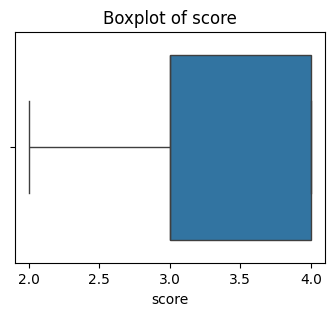

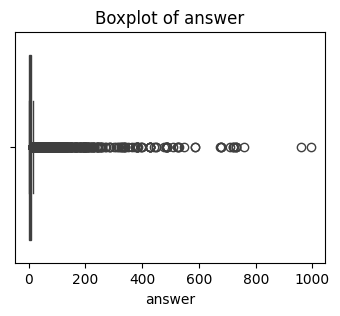

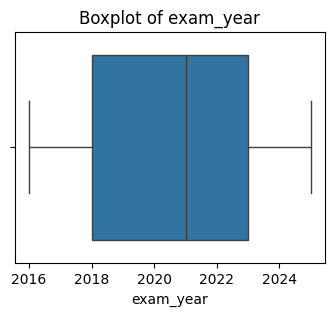

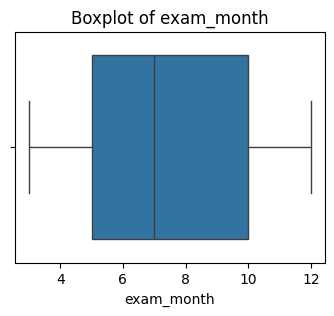

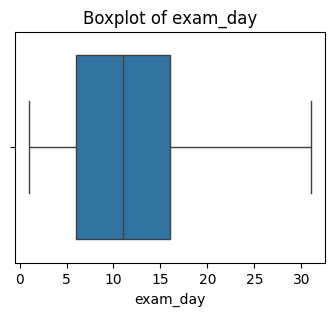

In [7]:
cols = ['score', 'answer', 'exam_year', 'exam_month', 'exam_day']

for col in cols:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x=X[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

<h4 id="contents2-4">2-4. 스케일링 방식 결정</h4>

[⬆ 목차로](#toc)

---

이상치가 없는 4개의 컬럼은 `MinMaxScaler`를 사용하면 됩니다.

`answer` 컬럼의 경우:
- 객관식: 값이 1~5
- 주관식: 값이 1~999

이렇게 데이터가 작은 값에 많이 몰려 있는 경우에는 로그 변환 후 `MinMaxScaler`를 적용하는 것이 좋습니다.

In [8]:
# 스케일링할 컬럼
cols = ['score', 'answer', 'exam_year', 'exam_month', 'exam_day']

# answer 컬럼만 로그 변환
X['answer'] = np.log1p(X['answer'])

# MinMaxScaler 적용
scaler = MinMaxScaler()
X[cols] = scaler.fit_transform(X[cols])

# 확인
X[cols].head(10)

,score,answer,exam_year,exam_month,exam_day
0,0.0,0.176922,1.0,0.222222,0.233333
1,0.0,0.000000,1.0,0.222222,0.233333
2,0.5,0.111625,1.0,0.222222,0.233333
3,0.5,0.000000,1.0,0.222222,0.233333
4,0.5,0.147560,1.0,0.222222,0.233333
5,0.5,0.176922,1.0,0.222222,0.233333
6,0.5,0.065297,1.0,0.222222,0.233333
7,0.5,0.000000,1.0,0.222222,0.233333
8,1.0,0.147560,1.0,0.222222,0.233333
9,1.0,0.111625,1.0,0.222222,0.233333


문제가 될 수 있는 `answer` 컬럼만 다시 시각화해봅시다

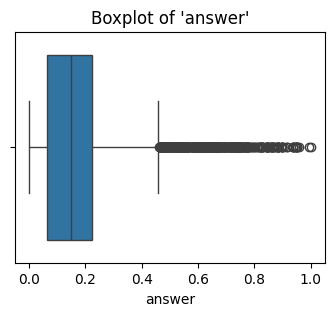

In [9]:
plt.figure(figsize=(4, 3))
sns.boxplot(x=X['answer'])
plt.title("Boxplot of 'answer'")
plt.show()

`answer` 컬럼은 여전히 왼쪽으로 치우친 분포를 보이고 있습니다.

모델에 따라 값이 몰린 것이 학습에 영향을 줄 수 있으므로,  

나중에 성능이 낮게 나올 경우 범주형(bin)으로 변환하는 방법을 고려하겠습니다.

<h4 id="contents2-5">2-5. Target변수 전처리</h4>

[⬆ 목차로](#toc)

---

`difficulty`변수는 현재 문자형 범주이기 때문에 모델에 바로 넣을 수 없습니다

라벨 인코딩으로 난이도를 수치로 변환하겠습니다

In [10]:
# 타겟 순서 지정
difficulty_order = ['하', '중하', '중', '중상', '상', '최상']

# 맵핑 딕셔너리 생성
difficulty_map = {label: idx for idx, label in enumerate(difficulty_order)}

# y(difficulty) 레이블 인코딩
y = y.map(difficulty_map)

# 확인
y

0       0
1       0
2       1
3       0
4       0
       ..
4735    5
4736    4
4737    3
4738    2
4739    5
Name: difficulty, Length: 4740, dtype: int64

<h4 id="contents2-6">2-6. 모델 학습</h4>

[⬆ 목차로](#toc)

---

학습데이터로 교차검증(cross validation) 시킨 후 f1 score를 출력합니다

그리고 훈련데이터로 최종 성능을 평가합니다

In [11]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True, 
    random_state=42, 
    stratify=y
)

# 사용할 모델들 정의
models = {
    "LogisticRegression": LogisticRegression(
        random_state=42
        ),
    "RandomForest": RandomForestClassifier(
        random_state=42
        ),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(
        random_state=42
        ),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, 
        eval_metric='mlogloss', 
        random_state=42
        )
}

# F1-score를 macro 기준으로 계산
scorer = make_scorer(
    f1_score, 
    average="macro"
    )  # macro: 클래스 불균형이 있을 때 모든 클래스에 균등 가중치 적용

# 모델별 하이퍼파라미터 후보
param_grids = {
    "LogisticRegression": {
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"]
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10],
        "min_samples_split": [2, 5]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1]
    }
}


# 결과 저장용
results = {}


kf = KFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
    )

for name, model in tqdm(models.items(), desc="Model Progress"):
    print(f"===== {name} GridSearchCV =====")
    
    grid = GridSearchCV(
        model, 
        param_grids[name], 
        cv=kf, 
        scoring=scorer, 
        n_jobs=-1
        )
    grid.fit(X_train, y_train)  # ✅ train셋 학습 + 교차검증
    
    # 교차검증 최고 성능
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV F1-score: {grid.best_score_:.4f}\n")
    
    # test셋 최종 성능
    y_pred = grid.predict(X_test)
    f1 = f1_score(
        y_test, 
        y_pred, 
        average="macro"  # macro: 클래스 불균형이 있을 때 모든 클래스에 균등 가중치 적용
    ) 

    print(f"Test F1: {f1:.4f}")
    print("="*40)
          
    results[name] = {
        "best_model": grid.best_estimator_,
        "cv_F1-score": round(grid.best_score_, 4),
        "test_F1-score": round(f1, 4)
    }


Model Progress:   0%|          | 0/5 [00:00<?, ?it/s]

===== LogisticRegression GridSearchCV =====


Model Progress:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Best params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-score: 0.4357

Test F1: 0.4296
===== RandomForest GridSearchCV =====


Model Progress:  40%|████      | 2/5 [00:09<00:15,  5.27s/it]

Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1-score: 0.7557

Test F1: 0.7477
===== GradientBoosting GridSearchCV =====


Model Progress:  60%|██████    | 3/5 [00:37<00:30, 15.47s/it]

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best CV F1-score: 0.8195

Test F1: 0.8201
===== SVM GridSearchCV =====


Model Progress:  80%|████████  | 4/5 [00:39<00:10, 10.35s/it]

Best params: {'C': 10, 'kernel': 'rbf'}
Best CV F1-score: 0.5971

Test F1: 0.5970
===== XGBoost GridSearchCV =====


Model Progress: 100%|██████████| 5/5 [00:46<00:00,  9.39s/it]

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best CV F1-score: 0.8264

Test F1: 0.8273


점수가 괜찮은 RandomForest, GradientBoosting, XGBoost 세 모델만 점수를 출력해보겠습니다

In [12]:
# DataFrame으로 정리
results_df = pd.DataFrame(results)
results_df = results_df.loc[:, ['RandomForest', 'GradientBoosting', 'XGBoost']]
results_df

,RandomForest,GradientBoosting,XGBoost
best_model,"(DecisionTreeClassifier(max_features='sqrt', m...",([DecisionTreeRegressor(criterion='friedman_ms...,"XGBClassifier(base_score=None, booster=None, c..."
cv_F1-score,0.7557,0.8195,0.8264
test_F1-score,0.7477,0.8201,0.8273


<h4 id="contents2-7">2-7. 모델 성능 시각화</h4>

[⬆ 목차로](#toc)

---

cv(train)점수와 test점수를 시각화해서 비교해보겠습니다

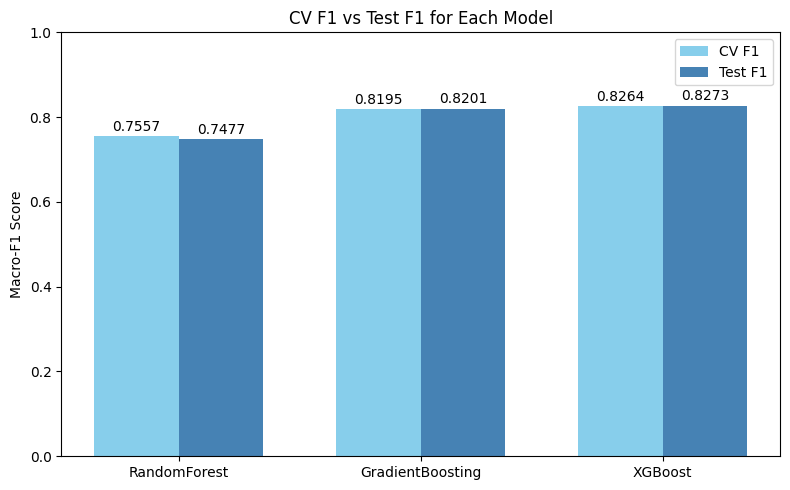

In [13]:
# 모델 이름
models_list = ["RandomForest", "GradientBoosting", "XGBoost"]

cv_f1 = results_df.loc['cv_F1-score']
test_f1 = results_df.loc['test_F1-score']

x = np.arange(len(models_list))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, cv_f1, width, label='CV F1', color='skyblue')        # cv_f1 
bars2 = ax.bar(x + width/2, test_f1, width, label='Test F1', color='steelblue')  # test_f1

# 값 표시 (다중 막대그래프)
for b1, b2 in zip(bars1, bars2):
    ax.text(b1.get_x() + b1.get_width()/2, b1.get_height() + 0.005, f'{b1.get_height():.4f}', ha='center', va='bottom', fontsize=10)
    ax.text(b2.get_x() + b2.get_width()/2, b2.get_height() + 0.005, f'{b2.get_height():.4f}', ha='center', va='bottom', fontsize=10)

# 레이블, 제목, 범례
ax.set_xticks(x)
ax.set_xticklabels(models_list)
ax.set_ylim(0, 1)
ax.set_ylabel('Macro-F1 Score')
ax.set_title('CV F1 vs Test F1 for Each Model')
ax.legend()

plt.tight_layout()
plt.show()

<h4 id="contents2-8">2-8. 모델 선정</h4>

[⬆ 목차로](#toc)

---

시각화 결과, XGBoost가 가장 우수한 성능을 나타냈습니다.

In [14]:
final_model = results['XGBoost']['best_model']
final_model

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


<h4 id="contents2-9">2-9. 특성 중요도 확인</h4>

[⬆ 목차로](#toc)

---

각 feature가 난이도 분류에 얼마나 기여하는지 중요도를 출력해봅시다.

In [15]:
feat_importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
feat_importances = feat_importances.sort_values(ascending=False)
feat_importances

score                0.254486
question_type_객관식    0.147163
option2              0.096536
option3              0.095313
option4              0.083660
option5              0.064837
subject_미적분          0.055330
option1              0.047473
answer               0.027943
subject_수학(나)        0.022724
subject_확률과통계        0.017891
exam_year            0.015972
subject_수학(가)        0.013186
exam_month           0.013092
subject_기하           0.012344
exam_type_학력평가       0.011985
exam_type_모의평가       0.009067
exam_day             0.006775
exam_type_수능         0.004222
question_type_주관식    0.000000
dtype: float32

`배점`과 `문제유형`이 `난이도` 분류에 가장 큰 영향을 미친 feature로 확인됩니다.

<h4 id="contents2-10">2-10. unseen 데이터 테스트</h4>

[⬆ 목차로](#toc)

---

모델 학습이나 평가에 사용되지 않은 최신 시험 데이터(출처: 메가스터디) 중, 한 문제를 선택했습니다.

2025년 7월 10일 고3 학력평가 기하 14번 문제(실제 난이도: 중상) 채점 결과를 사용하여 테스트를 진행합니다.

메가스터디 페이지에서 추출한 데이터는 다음과 같습니다.

| 번호 | 정답 | 난이도 | 배점 | 정답률 | 선지1 | 선지2 | 선지3 | 선지4 | 선지5 |
|------|------|--------|------|--------|-------|-------|-------|-------|-------|
| 14   | 2    | 중상     | 4    | 57%    | 10%   | 57%   | 9%   | 13%    | 11%    |

난이도 예측을 위해 `난이도`와, 이미 `난이도`에 의존하는 `정답률`은 제외합니다.

일부 컬럼에는 이전에 적용한 인코딩 방식을 적용한 값을 사용합니다.

In [16]:
sample_difficulty = '중상'
sample = pd.Series({
    'score': 4,
    'answer': 2,
    'option1': 0.10,
    'option2': 0.57,
    'option3': 0.09,
    'option4': 0.13,
    'option5': 0.11,
    'subject_기하': 1,
    'subject_미적분': 0,
    'subject_수학(가)': 0,
    'subject_수학(나)': 0,
    'subject_확률과통계': 0,
    'exam_type_모의평가': 0,
    'exam_type_수능': 0,
    'exam_type_학력평가': 1,
    'question_type_객관식': 1,
    'question_type_주관식': 0,
    'exam_date': '2025-07-10'
})

def scaling_sample(sample: pd.Series) -> pd.Series:
    
    # exam_date를 year, month, day 분리
    exam_date = pd.to_datetime(sample['exam_date'])
    sample['exam_year'] = exam_date.year
    sample['exam_month'] = exam_date.month
    sample['exam_day'] = exam_date.day
    sample = sample.drop('exam_date')
    
    # 로그 변환
    sample['answer'] = np.log1p(sample['answer'])
    
    # 스케일링
    cols_to_scale = ['score', 'answer', 'exam_year', 'exam_month', 'exam_day']
    sample[cols_to_scale] = scaler.transform([sample[cols_to_scale]])[0]  # 기존에 썼던 스케일러 재사용
    
    return sample

sample = scaling_sample(sample)
sample

score                     1.0
answer               0.065297
option1                   0.1
option2                  0.57
option3                  0.09
option4                  0.13
option5                  0.11
subject_기하                  1
subject_미적분                 0
subject_수학(가)               0
subject_수학(나)               0
subject_확률과통계               0
exam_type_모의평가              0
exam_type_수능                0
exam_type_학력평가              1
question_type_객관식           1
question_type_주관식           0
exam_year                 1.0
exam_month           0.444444
exam_day                  0.3
dtype: object

In [17]:
prediction = final_model.predict(sample.values.reshape(1, -1))
print(f"예측값: {prediction}")
print(f"예측 난이도: {difficulty_order[prediction[0]]}")
print(f"실제 난이도: {sample_difficulty}")

예측값: [3]
예측 난이도: 중상
실제 난이도: 중상


3 은 '중상' 난이도를 의미하므로, 예측 난이도가 실제 난이도와 일치합니다

'난이도' 컬럼의 인코딩 방식은 다음과 같습니다.

| 난이도 | 인코딩 값 |
| ------ | --- |
| 하 | 0 |
| 중하 | 1 |
| 중 | 2 |
| 중상 | 3 |
| 상 | 4 |
| 최상 | 5 |

